Imports

In [1]:
!pip install -q grad-cam

from utils import imshow
from ImagenetteDataset import ImagenetteDataset
from load_model import load_model
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torchvision, torch, torchvision.transforms as T
#from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm

Configure Size of Imagenette Pictures and PyTorch Device

In [2]:
#160 uses ~8GB RAM, 320 uses ~24GB RAM, Fullsize not tested
size = 160


if torch.cuda.is_available():
  device = torch.device('cuda:0')
# elif torch.backends.mps.is_available():
#   device = torch.device("mps")
#   import os
#   os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
else:
  device = "cpu"

print(device)

cpu


Download and unpack images

In [3]:

if not os.path.isfile(f'imagenette2-{size}.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-{size}.tgz
    !tar -xf imagenette2-{size}.tgz



Load Model and target Layers for GradCam

In [4]:
model, target_layers = load_model('mobilenet', norm_layer=True)


In [5]:
print(model)



Sequential(
  (0): ImageNetNormalization()
  (1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
       

Build our DataLoaders

In [6]:
bs = 256

trainset = ImagenetteDataset(size, should_normalize=False)
valset = ImagenetteDataset(size, validation=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = bs, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = bs, shuffle = False)




Get first Batch for Testing

In [7]:
data_batch, labels_batch = next(iter(trainloader))
print(data_batch.size())
print(labels_batch.size())
out = torchvision.utils.make_grid(data_batch)

torch.Size([256, 3, 160, 160])
torch.Size([256])


Predict First Batch with our model

In [8]:
class_names = trainset.classes
print(class_names)
outputs = model(data_batch.to(device))
print(outputs.shape)
imagenette_classes = [0,217,482,491,497,566,569,571,574,701]
myoutputs = torch.index_select(outputs,1,torch.tensor(imagenette_classes).to(device))
print(myoutputs.shape)

_, preds = torch.max(myoutputs,1)
print(labels_batch)
print(preds)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
torch.Size([256, 1000])
torch.Size([256, 10])
tensor([5, 8, 7, 3, 6, 8, 7, 8, 3, 1, 1, 9, 5, 7, 9, 3, 3, 8, 3, 2, 4, 5, 0, 5,
        0, 3, 0, 2, 2, 0, 4, 4, 0, 6, 0, 0, 4, 7, 4, 2, 7, 5, 4, 1, 7, 9, 5, 6,
        3, 3, 5, 8, 5, 4, 9, 2, 8, 1, 9, 7, 5, 2, 3, 5, 2, 0, 5, 5, 3, 9, 6, 3,
        7, 6, 9, 0, 0, 4, 9, 5, 8, 1, 3, 7, 5, 5, 8, 7, 7, 1, 8, 2, 6, 1, 5, 7,
        0, 0, 7, 2, 2, 5, 8, 7, 2, 9, 0, 4, 1, 0, 2, 6, 5, 0, 7, 6, 0, 4, 7, 1,
        9, 8, 5, 6, 0, 2, 5, 3, 0, 7, 1, 1, 7, 5, 4, 3, 7, 2, 5, 3, 7, 2, 4, 8,
        6, 1, 3, 0, 0, 9, 5, 5, 4, 3, 6, 1, 5, 2, 7, 8, 3, 8, 6, 3, 1, 6, 5, 7,
        5, 6, 8, 9, 5, 2, 0, 1, 2, 7, 0, 0, 0, 7, 7, 1, 0, 2, 6, 5, 2, 4, 4, 4,
        3, 4, 0, 5, 2, 1, 2, 2, 7, 6, 2, 1, 2, 9, 7, 3, 8, 1, 1, 6, 1, 2, 9, 5,
        5, 2, 0, 9, 7, 8, 3, 7, 6, 0, 2, 5, 4, 0, 6, 9, 7, 5, 2, 0, 7, 6, 4, 3,
        1, 0, 1, 0, 1, 

In [9]:
print(preds)

tensor([5, 0, 7, 3, 6, 8, 7, 8, 4, 1, 8, 9, 5, 7, 9, 3, 3, 8, 3, 2, 4, 5, 0, 5,
        0, 3, 0, 2, 2, 0, 4, 4, 0, 6, 0, 0, 4, 7, 4, 2, 7, 5, 4, 1, 7, 9, 5, 6,
        3, 3, 5, 8, 5, 4, 9, 2, 8, 1, 9, 7, 5, 2, 3, 5, 2, 0, 5, 5, 3, 9, 6, 3,
        7, 6, 3, 0, 0, 4, 9, 5, 8, 1, 3, 7, 5, 5, 8, 7, 7, 1, 8, 2, 6, 1, 5, 7,
        0, 0, 7, 2, 2, 5, 8, 7, 2, 9, 0, 4, 1, 0, 2, 6, 5, 0, 7, 6, 0, 4, 7, 1,
        9, 8, 5, 6, 0, 2, 5, 3, 0, 7, 1, 1, 7, 5, 4, 3, 7, 2, 5, 3, 7, 2, 4, 8,
        6, 1, 7, 0, 0, 9, 5, 5, 4, 3, 6, 1, 5, 2, 7, 8, 3, 8, 6, 3, 1, 6, 5, 7,
        5, 6, 8, 9, 5, 2, 0, 1, 2, 7, 0, 0, 0, 7, 7, 1, 0, 2, 6, 5, 2, 4, 4, 4,
        3, 4, 0, 5, 2, 1, 2, 2, 7, 6, 2, 1, 2, 9, 7, 3, 8, 3, 1, 6, 1, 4, 9, 5,
        5, 2, 0, 9, 7, 8, 3, 7, 6, 0, 2, 2, 4, 0, 6, 9, 7, 5, 2, 0, 7, 6, 4, 3,
        1, 0, 1, 0, 1, 4, 9, 6, 8, 4, 4, 8, 2, 6, 1, 8])


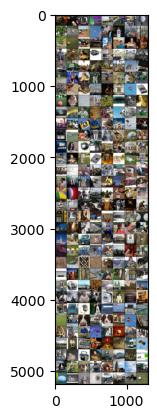

In [10]:
imshow(out, denorm=False)#, title=[class_names[x] for x in preds])

Run Inference on whole trainset

In [11]:
all_predictions = []
num_correct = 0
with torch.no_grad():
  loop = tqdm(trainloader)
  for idx, (data, labels) in enumerate(loop):
    outputs = model(data.to(device))
    #These are the imagenette classes
    imagenette_classes = [0,217,482,491,497,566,569,571,574,701]
    # We only want to look at the imagenette classes
    imagenette_outputs = torch.index_select(outputs,1,torch.tensor(imagenette_classes).to(device))
    _, preds = torch.max(imagenette_outputs,1)
    all_predictions.extend(preds)
    corrects = torch.sum(preds == labels.to(device))
    num_correct += corrects
    loop.set_description(f"Processing batch {idx+1}")
    loop.set_postfix(current_accuracy = num_correct.double().item()/(len(labels)*(idx+1)))
    #print(f"Done with batch of size {(len(labels))}")
pred = torch.stack(all_predictions)



Processing batch 37: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, current_accuracy=0.98] 


In [12]:
print("Accuracy: {:.4f}".format(num_correct.double()/len(trainset)))

Accuracy: 0.9690


In [13]:
print(pred.size())
print(pred[0:100])

torch.Size([9469])
tensor([5, 6, 0, 9, 6, 9, 9, 5, 0, 9, 9, 9, 2, 6, 2, 0, 2, 7, 9, 5, 8, 8, 4, 2,
        5, 8, 2, 1, 1, 8, 1, 4, 6, 0, 1, 4, 8, 9, 1, 2, 9, 7, 5, 7, 4, 3, 0, 5,
        8, 1, 7, 9, 9, 0, 7, 7, 8, 4, 2, 4, 2, 3, 2, 8, 0, 1, 0, 4, 1, 3, 9, 4,
        9, 2, 6, 4, 4, 3, 8, 5, 5, 8, 7, 4, 5, 9, 5, 8, 8, 5, 4, 4, 0, 7, 7, 2,
        8, 3, 7, 0])


Run Grad-Cam

In [14]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
#with torch.no_grad():
# 3:23 for 320px and resnet50
# 2:33 for 320px and mobilenetv3
dirname=f'output_{size}'
os.makedirs(dirname, exist_ok=True)
loop = tqdm(trainloader)
for batch, (data, labels) in enumerate(loop):
  grayscale_cam = cam(input_tensor=data, targets=None)
  #for idx in range(len(grayscale_cam)):
    #image=data[idx,:,:,:].cpu().numpy().transpose(1,2,0)
    #print(image)
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #image=std*image+mean
    #image = np.clip(image, 0, 1)
    #visualization = show_cam_on_image(image, grayscale_cam[idx,:])#, use_rgb=True)
    #status = cv2.imwrite(f'{dirname}/{trainloader.batch_size*batch+idx}.JPEG',visualization)




100%|██████████| 37/37 [18:11<00:00, 29.50s/it]


Explainability with Pytorch Captum

In [15]:
!pip install -q git+https://github.com/pytorch/captum.git

from captum.attr import IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Integrated Gradients

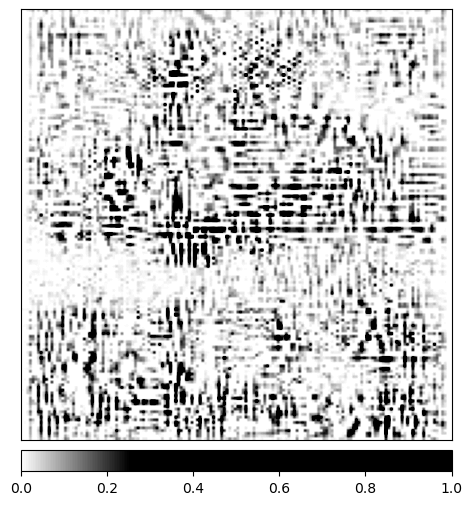

In [16]:

ig = IntegratedGradients(model)
data, labels = next(iter(trainloader))
idx = 4
input = data[idx].unsqueeze(0).to(device)
label = labels[idx].to(device)
#print (data[0].size())
attributions = ig.attribute(input, target=label, n_steps=100)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


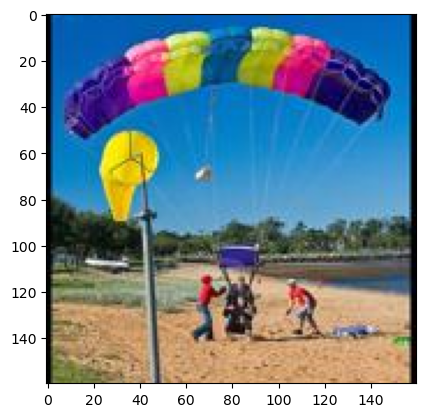

In [17]:
imshow(data[idx], denorm=False)

Noise Tunnel for Smooting

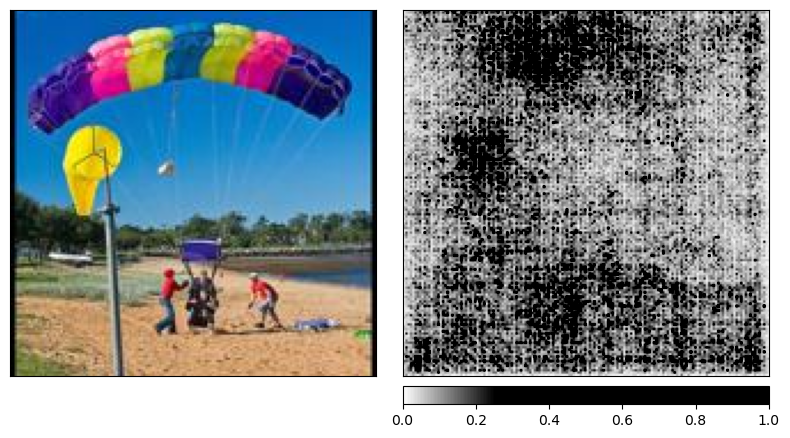

In [18]:
# nt_samples <= 7 for 15GB VRAM 
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=label)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [19]:
#plt.imshow(show_cam_on_image(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
 #                                     np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)), use_rgb=True))